In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:

# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
data = read_text("/content/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [ ]:
len(deu_eng)

234215

In [ ]:

deu_eng = deu_eng[:100000,:]

In [ ]:

deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["It's good to see you smile.",
        'Es ist schön, dich lächeln zu sehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4832310 (Hybrid) & #6128764 (Pfirsichbaeumchen)'],
       ["It's good to see you smile.",
        'Es ist schön, Sie lächeln zu sehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4832310 (Hybrid) & #6128766 (Pfirsichbaeumchen)'],
       ["It's hard to say no to Tom.",
        'Es ist schwer, Tom etwas abzuschlagen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3394352 (CK) & #3411708 (Pfirsichbaeumchen)']],
      dtype='<U120')

In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [ ]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Its good to see you smile',
        'Es ist schön dich lächeln zu sehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4832310 (Hybrid) & #6128764 (Pfirsichbaeumchen)'],
       ['Its good to see you smile', 'Es ist schön Sie lächeln zu sehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4832310 (Hybrid) & #6128766 (Pfirsichbaeumchen)'],
       ['Its hard to say no to Tom',
        'Es ist schwer Tom etwas abzuschlagen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3394352 (CK) & #3411708 (Pfirsichbaeumchen)']],
      dtype='<U120')

In [ ]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [ ]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['its good to see you smile',
        'es ist schön dich lächeln zu sehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4832310 (Hybrid) & #6128764 (Pfirsichbaeumchen)'],
       ['its good to see you smile', 'es ist schön sie lächeln zu sehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4832310 (Hybrid) & #6128766 (Pfirsichbaeumchen)'],
       ['its hard to say no to tom',
        'es ist schwer tom etwas abzuschlagen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3394352 (CK) & #3411708 (Pfirsichbaeumchen)']],
      dtype='<U120')

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

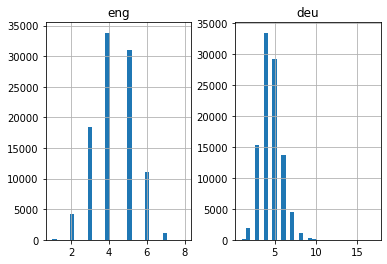

In [ ]:

length_df.hist(bins = 30)
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 8955


In [ ]:

# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 15980


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)


In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [ ]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:

# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'model.h7.29_jul_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
125/125 [==============================] - 573s 4s/step - loss: 4.2823 - val_loss: 3.4322

Epoch 00001: val_loss improved from inf to 3.43224, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 2/30
125/125 [==============================] - 547s 4s/step - loss: 3.1370 - val_loss: 2.9387

Epoch 00002: val_loss improved from 3.43224 to 2.93874, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 3/30
125/125 [==============================] - 547s 4s/step - loss: 2.8303 - val_loss: 2.7258

Epoch 00003: val_loss improved from 2.93874 to 2.72584, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 4/30
125/125 [==============================] - 545s 4s/step - loss: 2.6007 - val_loss: 2.5251

Epoch 00004: val_loss improved from 2.72584 to 2.52513, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 5/30
125/125 [==============================] - 545s 4s/step - loss: 2.3843 - val_loss: 2.3615

Epoch 00005: val_loss improved from 2.52513 to 2.36148, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 6/30
125/125 [==============================] - 545s 4s/step - loss: 2.2073 - val_loss: 2.2037

Epoch 00006: val_loss improved from 2.36148 to 2.20366, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 7/30
125/125 [==============================] - 541s 4s/step - loss: 2.0131 - val_loss: 2.0502

Epoch 00007: val_loss improved from 2.20366 to 2.05015, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 8/30
125/125 [==============================] - 542s 4s/step - loss: 1.8273 - val_loss: 1.9243

Epoch 00008: val_loss improved from 2.05015 to 1.92427, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 9/30
125/125 [==============================] - 547s 4s/step - loss: 1.6649 - val_loss: 1.8084

Epoch 00009: val_loss improved from 1.92427 to 1.80843, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 10/30
125/125 [==============================] - 542s 4s/step - loss: 1.5188 - val_loss: 1.7301

Epoch 00010: val_loss improved from 1.80843 to 1.73009, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 11/30
125/125 [==============================] - 543s 4s/step - loss: 1.3902 - val_loss: 1.6415

Epoch 00011: val_loss improved from 1.73009 to 1.64152, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 12/30
125/125 [==============================] - 545s 4s/step - loss: 1.2684 - val_loss: 1.5736

Epoch 00012: val_loss improved from 1.64152 to 1.57356, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 13/30
125/125 [==============================] - 542s 4s/step - loss: 1.1582 - val_loss: 1.5183

Epoch 00013: val_loss improved from 1.57356 to 1.51827, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 14/30
125/125 [==============================] - 545s 4s/step - loss: 1.0604 - val_loss: 1.4906

Epoch 00014: val_loss improved from 1.51827 to 1.49060, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 15/30
125/125 [==============================] - 539s 4s/step - loss: 0.9714 - val_loss: 1.4608

Epoch 00015: val_loss improved from 1.49060 to 1.46077, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 16/30
125/125 [==============================] - 539s 4s/step - loss: 0.8937 - val_loss: 1.4169

Epoch 00016: val_loss improved from 1.46077 to 1.41689, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 17/30
125/125 [==============================] - 539s 4s/step - loss: 0.8203 - val_loss: 1.3840

Epoch 00017: val_loss improved from 1.41689 to 1.38400, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 18/30
125/125 [==============================] - 539s 4s/step - loss: 0.7504 - val_loss: 1.3657

Epoch 00018: val_loss improved from 1.38400 to 1.36568, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 19/30
125/125 [==============================] - 539s 4s/step - loss: 0.6926 - val_loss: 1.3531

Epoch 00019: val_loss improved from 1.36568 to 1.35313, saving model to model.h7.29_jul_21


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


INFO:tensorflow:Assets written to: model.h7.29_jul_21/assets


Epoch 20/30
125/125 [==============================] - 541s 4s/step - loss: 0.6317 - val_loss: 1.3745

Epoch 00020: val_loss did not improve from 1.35313
Epoch 21/30
 88/125 [====================>.........] - ETA: 2:28 - loss: 0.5695

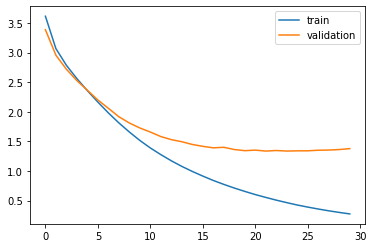

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
testX.reshape(testX.shape[0],testX.shape[1])

array([[   1,  218,    4, ...,    0,    0,    0],
       [   1,   49,    6, ...,  401,   12,  115],
       [   2,  990,   40, ...,    0,    0,    0],
       ...,
       [ 187,    1,   48, ...,    0,    0,    0],
       [   7,   41,  104, ...,    0,    0,    0],
       [   1,   19, 3862, ...,    0,    0,    0]], dtype=int32)

In [ ]:
testX

array([[   1,  218,    4, ...,    0,    0,    0],
       [   1,   49,    6, ...,  401,   12,  115],
       [   2,  990,   40, ...,    0,    0,    0],
       ...,
       [ 187,    1,   48, ...,    0,    0,    0],
       [   7,   41,  104, ...,    0,    0,    0],
       [   1,   19, 3862, ...,    0,    0,    0]], dtype=int32)

In [ ]:
(testX.reshape((testX.shape[0], testX.shape[1]))).shape

(20000, 8)

In [ ]:
model = load_model('/content/model.h7.29_jul_21')
preds = model.predict_classes(testX.reshape(testX.shape[0],testX.shape[1]))

ResourceExhaustedError: ignored

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:

pred_df.head(15)

Testing on email data


In [ ]:
stringg = """Guten Morgen Herr Tabib,
 
bin auf der Suche nach MCS7830CV-DA
 
Verical hat zwar 589 Stück am Lager , die reichen uns aber nicht.
Brauche eventuell 1000 weitere.
 
Angebot für 1k   MCS7830CV-DA  möglich? """


In [ ]:
# split text into sentences 
def to_lines(text): 
      sents = text.strip().split('\n') 
      sents = [i.split('\t') for i in sents] 
      return sents

In [ ]:
import numpy as np
data = stringg
input = to_lines(data)
input = array(input)


In [ ]:
input = [(str(s)).translate(str.maketrans('','',string.punctuation)) for s in input]

In [ ]:
type(input)

In [ ]:
input

In [ ]:
a = []
for word in input:
  a.append(word.lower())


In [ ]:
a

In [ ]:
input = a

In [ ]:
len(input)

In [ ]:
eng_l = [] 
for i in input:
      eng_l.append(len(i.split()))

In [ ]:
length_df = pd.DataFrame({'eng':eng_l, })
length_df.hist(bins = 30)
plt.show()

In [ ]:
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

In [ ]:
eng_tokenizer = tokenization(input) 

In [ ]:
eng_tokenizer

In [ ]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1 

In [ ]:
eng_vocab_size

In [ ]:
eng_length = 8 

In [ ]:
# encode and pad sequences 
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

In [ ]:
testX = encode_sequences(eng_tokenizer,eng_length, input)

In [ ]:
testX

In [ ]:
model = load_model('/content/model.h7.28_jul_21')

In [ ]:
preds = model.predict_classes(testX.reshape(testX.shape[0], testX.shape[1]))

In [ ]:
preds

In [ ]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
preds_text